In [25]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
import datetime
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

### Cargo los datos y sets

In [26]:
training_labels = pd.read_csv("set_entrenamiento.csv", low_memory=False)[['person','label']]
labels_predict = pd.read_csv("trocafone_kaggle_test.csv", low_memory=False)
events_data = pd.read_csv("data_set.csv", low_memory = False)

### Comenzamos con el set de entrenamiento

In [27]:
set_entrenamiento = pd.merge(events_data, training_labels, on ='person', how = 'right')

In [28]:
set_entrenamiento = set_entrenamiento.drop(columns = ['person'])
set_entrenamiento.head()

,Direct,Email,Organic,Paid,Referral,Social,Unknown,ad campaign hit,brand listing,checkout,...,lead,search engine hit,searched products,staticpage,viewed product,visited site,promedio dias,promedio hora,retornos,label
0,0,0,1,3,0,0,0,5,0,0,...,0,6,0,0,18,4,20.628571,16.971429,4,0
1,0,0,1,3,0,0,0,5,0,0,...,0,6,0,0,18,4,20.628571,16.971429,4,0
2,0,0,1,3,0,0,0,5,0,0,...,0,6,0,0,18,4,20.628571,16.971429,4,0
3,0,0,1,3,0,0,0,5,0,0,...,0,6,0,0,18,4,20.628571,16.971429,4,0
4,0,0,1,3,0,0,0,5,0,0,...,0,6,0,0,18,4,20.628571,16.971429,4,0


In [118]:
X = set_entrenamiento.drop(columns = ['label'])
y = set_entrenamiento["label"]

In [143]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=123)

In [144]:
data_dmatrix = xgb.DMatrix(data=X,label=y)

In [145]:
xg_reg = xgb.XGBRegressor(objective ='binary:logistic', 
                colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 5, n_estimators = 30)

In [146]:
xg_reg.fit(x_train,y_train)

XGBRegressor(alpha=5, base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.3, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=30,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [147]:
preds = xg_reg.predict(x_test)
preds = preds.tolist()
df = pd.DataFrame(preds)
media = df[0].mean()
std = df[0].std()
df.describe()

,0
count,61586.000000
mean,0.640342
std,0.242470
min,0.084816
25%,0.431245
50%,0.689828
75%,0.856999
max,0.960874


In [148]:
df = df[0].map(lambda x: 1 if x > media - std/2.6 else 0);
df = df.to_frame()
df.rename(columns = {0: 'label'},inplace = True) 

In [149]:
df['label'].value_counts()

1    38945
0    22641
Name: label, dtype: int64

In [150]:
accuracy_score(df,y_test)

0.9091351930633585

### Comenzamos con el set de test

In [151]:
set_test = pd.merge(events_data,labels_predict,on = "person", how = "right")
set_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19415 entries, 0 to 19414
Data columns (total 22 columns):
person               19415 non-null object
Direct               19415 non-null int64
Email                19415 non-null int64
Organic              19415 non-null int64
Paid                 19415 non-null int64
Referral             19415 non-null int64
Social               19415 non-null int64
Unknown              19415 non-null int64
ad campaign hit      19415 non-null int64
brand listing        19415 non-null int64
checkout             19415 non-null int64
conversion           19415 non-null int64
generic listing      19415 non-null int64
lead                 19415 non-null int64
search engine hit    19415 non-null int64
searched products    19415 non-null int64
staticpage           19415 non-null int64
viewed product       19415 non-null int64
visited site         19415 non-null int64
promedio dias        19415 non-null float64
promedio hora        19415 non-null float64
reto

In [152]:
personas = set_test["person"]
set_test = set_test.drop(columns=['person'])
set_test = set_test.fillna(0)

In [153]:
predicts_kaggel = xg_reg.predict(set_test)
set_test.tail()

,Direct,Email,Organic,Paid,Referral,Social,Unknown,ad campaign hit,brand listing,checkout,...,generic listing,lead,search engine hit,searched products,staticpage,viewed product,visited site,promedio dias,promedio hora,retornos
19410,0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,19,1,28.000000,14.476190,1
19411,0,0,0,1,0,0,0,1,0,1,...,0,0,0,0,0,1,1,22.000000,17.000000,1
19412,0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,18.000000,19.000000,1
19413,0,0,7,3,0,0,0,7,1,1,...,12,0,12,8,3,42,10,11.010309,17.896907,10
19414,0,0,0,1,0,0,0,1,2,1,...,0,0,1,0,0,4,1,17.000000,22.000000,1


In [154]:
predicts_kaggel = predicts_kaggel.tolist()
df_kaggel = pd.DataFrame(predicts_kaggel)
df_kaggel.head()

,0
0,0.464749
1,0.623506
2,0.689656
3,0.560432
4,0.460871


In [155]:
media = df_kaggel[0].mean()
std = df_kaggel[0].std()
df_kaggel[0].describe()

count    19415.000000
mean         0.431050
std          0.180673
min          0.172226
25%          0.279677
50%          0.366549
75%          0.578655
max          0.953909
Name: 0, dtype: float64

In [156]:
df_kaggel = df_kaggel[0].map(lambda x: 1 if x > media - std/2.6 else 0);
df_kaggel = df_kaggel.to_frame()
df_kaggel["person"] = personas
df_kaggel.rename(columns = {0: 'label'},inplace = True) 

In [157]:
df_kaggel = df_kaggel[['person','label']]

### Vemos resultados y pasamos a un csv

In [158]:
df_kaggel['label'].value_counts()

1    9859
0    9556
Name: label, dtype: int64

In [159]:
df_kaggel.to_csv('Resultados_xgb.csv',index=False)

### Vemos la importancia de cada feature

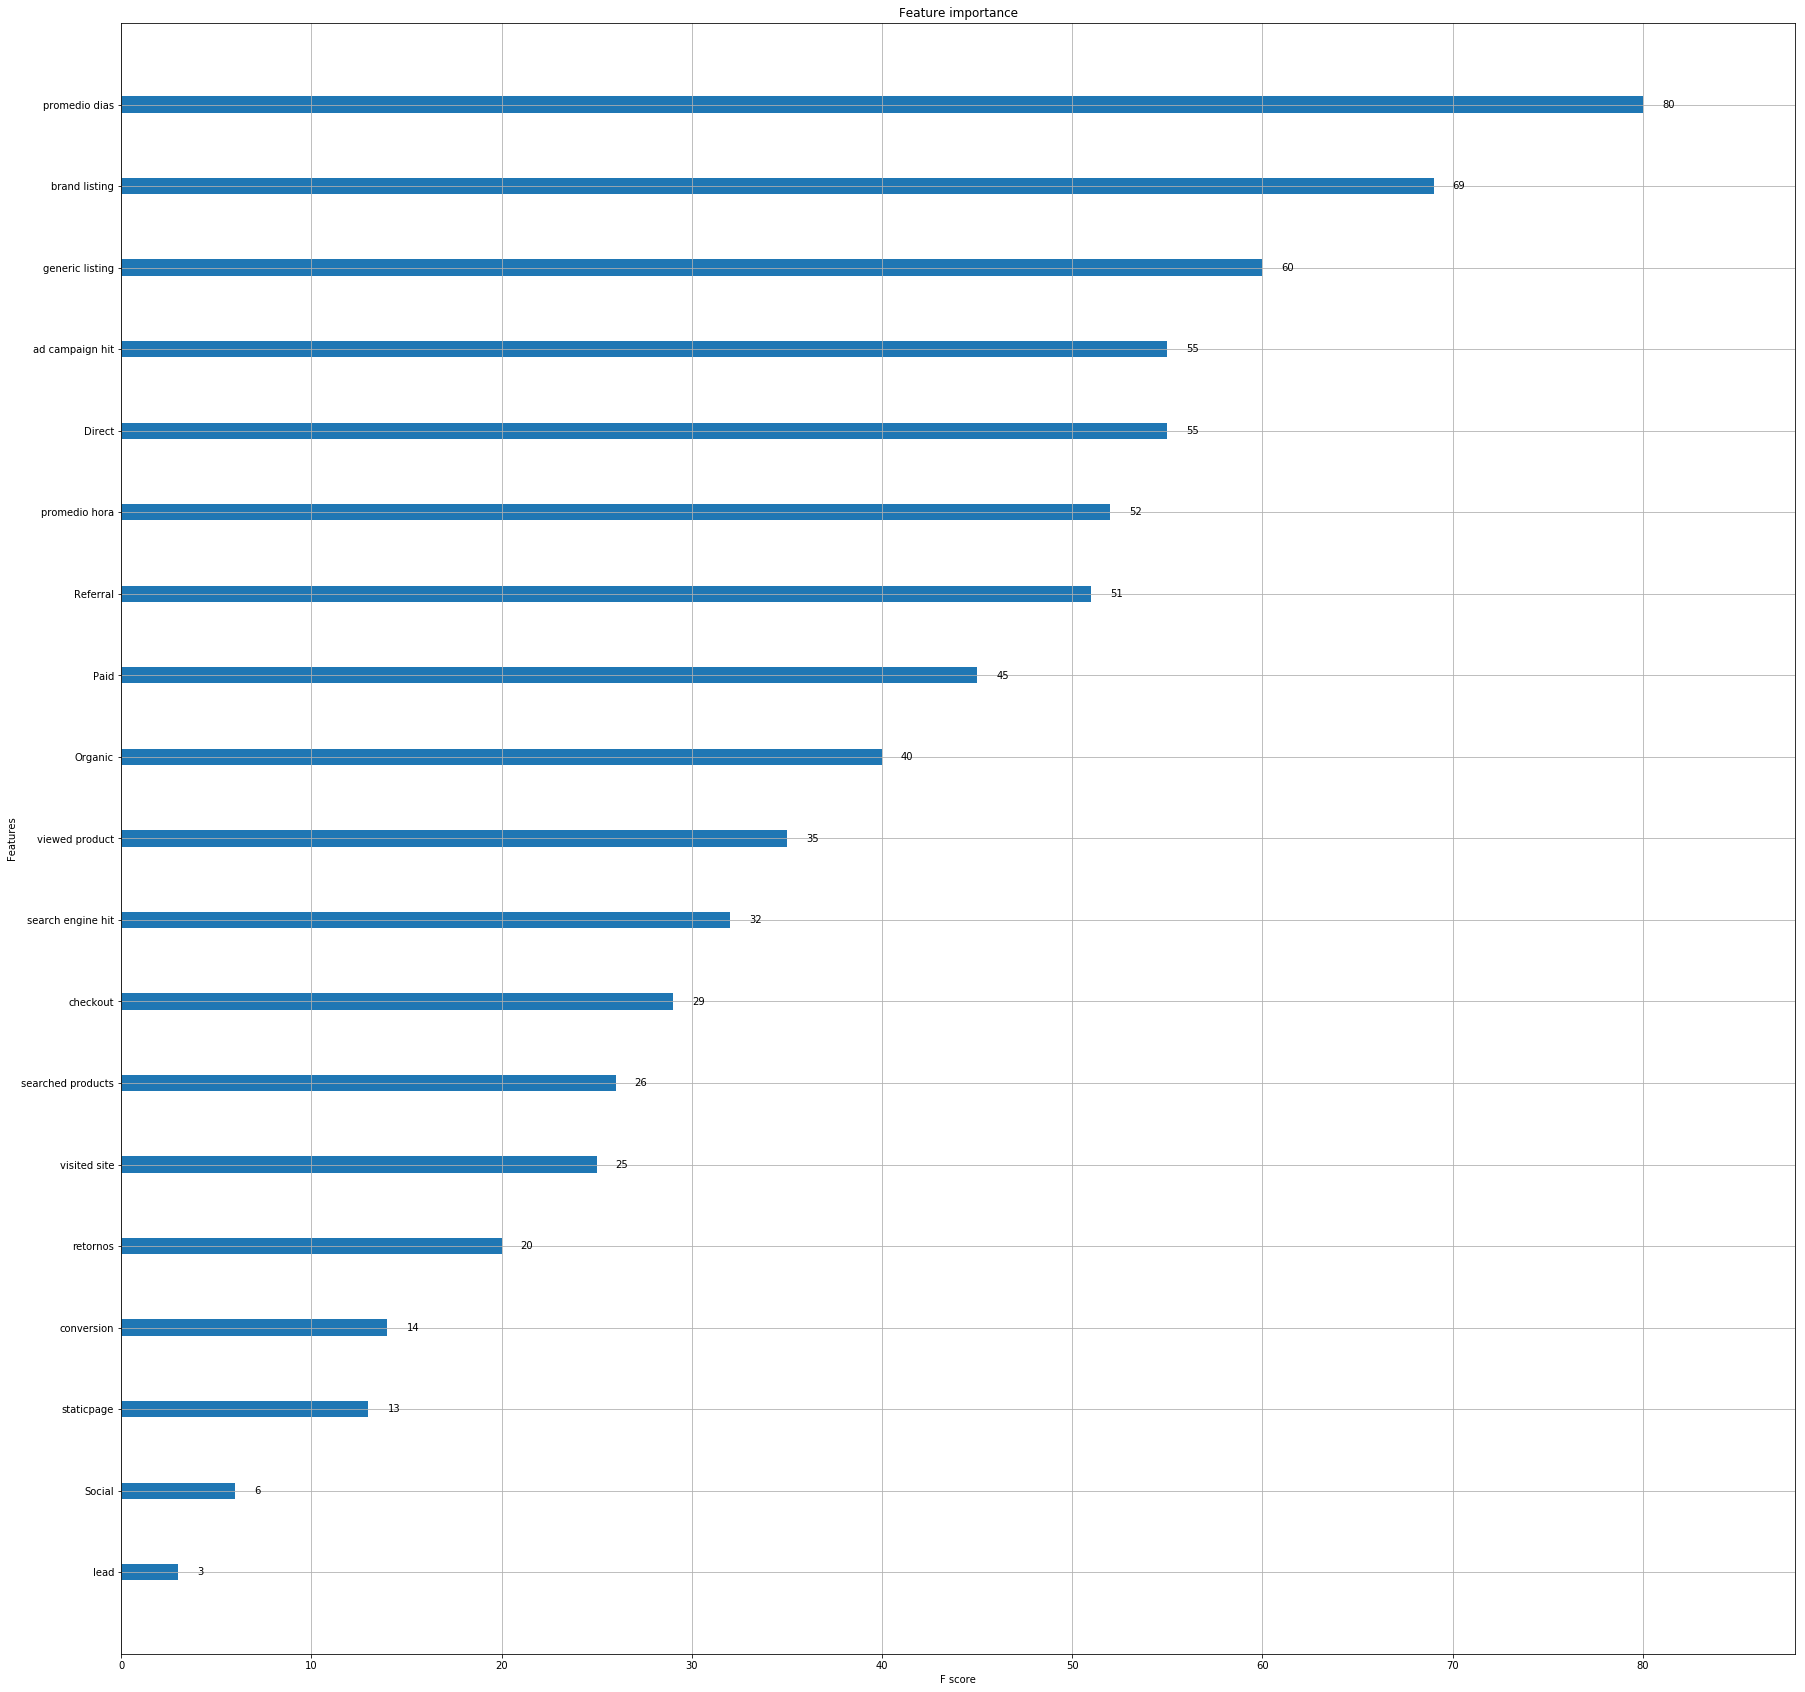

In [160]:
import matplotlib.pyplot as plt
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [30, 30]
plt.show()

In [24]:
#Pruebas anteriores
#marcas + condicion + color + storage + promedio dias+ promedio horas = malo (color aportaba muy poco) #0.74"
#marcas + condicion + storage + promedio dias+ promedio horas = safa (0.76110)
#condicion + storage + promedio dias+ promedio horas =  (0.76409)
#condicion + promedio dias+ promedio horas =  (0.76688)
# 6759
#
#